In [1]:
# !pip install nltk
# !pip install pytorch==1.9.0
# !pip install torchtext==0.10
# !pip install transformers==4.7
# !pip install fastai==2.4

# Installing Packages and Dependencies

In [2]:
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

STOPWORDS = stopwords.words('english')
lemmentizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denylson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Denylson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Denylson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import torch
from torch import nn
from torch import optim

In [4]:
import pandas as pd
import numpy as np
import random

In [5]:
import matplotlib.pyplot as plt

In [6]:
import torchtext
from torchtext.data import get_tokenizer

In [7]:
from fastai.text.all import *

# Getting Data

In [8]:
path = './data/balanced_clean_data.csv'

In [9]:
df = pd.read_csv(path)

In [10]:
df['Score'].value_counts()

 1    29770
 0    29770
-1    29770
Name: Score, dtype: int64

In [11]:
df['Score'] = df['Score'].replace([-1, 0, 1], [0, 2, 1])
df.head()

,Score,Text
0,1,"I always loved Shake and Bake for pork when I was a kid, but for some reason, I hadn't had it in many, many years. I'm not sure how today's formulation of it compares to it in the 1960's, but it's every bit as good as I remembered it. The instructions called for 1/2 inch chops that were to be cooked 15 minutes, which didn't seem long enough to me, but I was pleasantly surprised to find that they did get done all the way through and were still juicy and wonderful. I think most people over-cook pork trying to be careful and end up ruining it. The coating was crunchy and perfectly seasoned. T..."
1,2,"The flavor to me seems like just chili powder. It's just a matter of preference as to what you like. I've been mixing salsa in it to add some veggie flavors and textures, and for me it's an improvement..."
2,0,Truthfully wasn't crazy about the taste of these but reason for the low rating is more to post a heads up warning. I noticed a trend in drinking this with a headache response. From an old neck injury I could get headaches from reinjuring or aggravating it. This tea triggered that same response which was very surprising. It made me think that many people could be triggering similar inflammation without ever tracing it back to the tea. So just heads up if you are susceptible to this type of pain.
3,0,"I purchased this as a moisturizer for my hair. Very faint rose smell, almost non-exsistent. On the bottle the ingredients listed are 50% distilled water and 50% rose petals; that must be a mistake because all I smell is water."
4,0,"Pretty soon its going to be cheaper to have your coffee at Starbuck than buying Senseo coffee pods<a href=""http://www.amazon.com/gp/product/B000UBH9YO"">Senseo Medium Roast Coffee, 18-Count Pods (Pack of 6)</a>"


In [12]:
# df = df[df['Score'] != 2]

# Torchtext Glove and Tokenizer

In [13]:
EMB_SIZE = 100
glove = torchtext.vocab.GloVe(name = '6B', dim = EMB_SIZE)
glove.vectors.shape

torch.Size([400000, 100])

In [14]:
train_data = df[:int(len(df) * 0.75)]
test_data = df[int(len(df) * 0.75) : len(df)]


In [15]:
tokenizer = get_tokenizer('basic_english')

In [16]:
tokens = list(tokenizer(train_data['Text'][0]))
# tokens

In [17]:
# punctuation = ".,!?''"
# punctuations_removed = []

# for token in tokens:
#     if token not in punctuation:
#         punctuations_removed.append(token)

# punctuations_removed

In [18]:
# stops_removed = []
# for token in punctuations_removed:
#     if token not in STOPWORDS:
#         stops_removed.append(token)

# stops_removed

In [19]:
# lemmantized_list = []
# for token in stops_removed:
#     lemmantized = lemmentizer.lemmatize(token)
#     lemmantized_list.append(lemmantized)

# lemmantized_list

In [20]:
punctuation = ".,!?-()=+_|\/<>;:[]{}`~''"
token_counter = Counter()

for sample_text in train_data['Text']:
    tokens = tokenizer(sample_text)
    punctuations_removed = [token for token in tokens if token not in punctuation]
    stopwords_removed = [token for token in punctuations_removed if token not in STOPWORDS]
    lemmantized_list = [lemmentizer.lemmatize(token) for token in stopwords_removed]
    token_counter.update(lemmantized_list)
    
# token_counter.most_common(n = 25)

# Creating Vocabulary amd Numericalizing Tokens

In [21]:
sorted_counter = dict(token_counter.most_common())
my_vocab = torchtext.vocab.vocab(sorted_counter, min_freq = 70)

unk_token = '<unk>'
my_vocab.insert_token(unk_token, 0)
my_vocab.set_default_index(0)

pad_token = '<pad>'
my_vocab.insert_token(pad_token, 1)

len(my_vocab.get_itos()), my_vocab.get_itos()[:25]

(3690,
 ['<unk>',
  '<pad>',
  'like',
  'taste',
  'product',
  'good',
  'flavor',
  'one',
  'would',
  'coffee',
  'tea',
  'get',
  'food',
  'great',
  'love',
  'much',
  'really',
  'make',
  'amazon',
  'time',
  'box',
  'bag',
  'buy',
  'dog',
  'use'])

In [22]:
my_vocab.vectors = glove.get_vecs_by_tokens(my_vocab.get_itos())
my_vocab.vectors.shape

torch.Size([3690, 100])

In [23]:
tot_transferred = 0

for v in my_vocab.vectors:
    if not v.equal(torch.zeros(100)):
        tot_transferred += 1

tot_transferred, len(my_vocab)

(3613, 3690)

In [24]:
my_vocab.get_itos()[3], my_vocab.vectors[3]

('taste',
 tensor([-0.2466,  0.2876,  0.5639,  0.1210, -0.5443,  0.5535,  0.4960, -0.2352,
         -0.2111,  0.2786, -0.6362, -0.6102,  0.0670,  0.1267, -0.0125,  0.3316,
         -0.1242, -0.0655, -0.2958,  0.9826, -0.4516,  0.0421, -0.0535, -1.0911,
          0.0459,  1.0733,  0.0746, -0.4105,  0.3262, -0.6935, -0.1683,  0.8514,
         -0.6443, -0.3090, -0.0808,  0.5789, -0.0212,  0.6006, -0.0849, -0.7017,
          0.4353, -1.7349, -0.4485, -1.0450,  0.1289,  0.3302,  0.2004, -0.1133,
          0.2275, -1.1130,  0.3920, -0.0847, -0.5158,  0.8865, -0.3438, -1.2946,
          0.0250,  0.1104,  0.7369, -0.6131,  0.0471,  1.4001, -0.2480, -0.3326,
          0.8087, -0.8989,  0.3684, -1.0946, -0.4225, -0.6527, -0.2025,  0.7006,
          0.3021,  0.3794, -0.1251,  0.4189, -0.9431, -0.8895, -0.1244,  0.1794,
         -0.2261, -0.3976, -0.4175,  0.8627, -0.7797, -0.3807, -0.3657,  0.2564,
         -0.2054, -0.1444, -0.1614,  0.1357, -0.5889, -0.3084, -0.6956, -0.0863,
         -0.4651, 

In [25]:
my_vocab.get_itos()[2991], my_vocab.vectors[2991]

('biting',
 tensor([-0.2000, -0.5675,  0.7654, -0.7841, -0.1245,  0.6039, -0.5124, -0.1028,
         -0.4716, -0.4522, -0.3639, -0.0593,  0.2142,  0.4420,  0.7892,  0.7925,
         -0.8343, -0.8804,  0.3692, -0.2116,  0.7005,  0.1680,  0.0736,  0.0765,
          1.0400,  0.7752, -0.7941,  0.3706,  0.0018, -0.2773, -0.5395, -0.1976,
         -0.0813, -0.1775, -0.1967, -0.2798, -0.5150, -0.4117, -0.1065,  0.5288,
         -0.5701, -0.1953, -0.0637, -0.5799, -0.8697,  0.3774,  0.4637, -1.1163,
         -0.1312, -0.4549, -0.0766, -0.1130,  0.2668,  0.9551, -0.2303, -0.0748,
          0.5524,  0.0451,  0.5216, -0.5604,  1.0632,  1.3531, -0.6398,  0.2591,
          0.3140, -0.2464,  0.2831, -0.1497, -0.0455, -0.4530, -0.6667,  0.0215,
          0.3178,  0.5490, -0.8126, -0.3322, -0.5706, -0.4784, -0.2631,  0.6333,
          0.1951, -0.4590, -0.3727,  0.1857, -1.0325, -0.7079, -0.2748,  1.0662,
         -0.2458,  0.0631,  0.5523,  0.1019,  0.1954,  0.2858,  0.7243, -0.1441,
         -0.3941,

In [26]:
for i in range(my_vocab.vectors.shape[0]):
    if my_vocab.vectors[i].equal(torch.zeros(100)):
        my_vocab.vectors[i] = torch.randn(100)

In [27]:
tokens = list(tokenizer(train_data['Text'][0]))
# tokens

In [28]:
numericalized_tokens = [my_vocab[token] for token in tokens]
numericalized_tokens = torch.tensor(numericalized_tokens)
# numericalized_tokens

In [29]:
' '.join([my_vocab.get_itos()[num] for num in numericalized_tokens])

'<unk> always loved shake <unk> bake <unk> pork <unk> <unk> <unk> <unk> kid <unk> <unk> <unk> <unk> reason <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> many <unk> many <unk> <unk> <unk> <unk> <unk> <unk> sure <unk> today <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> every bit <unk> good <unk> <unk> remembered <unk> <unk> <unk> <unk> called <unk> 1/2 inch <unk> <unk> <unk> <unk> <unk> cooked 15 <unk> <unk> <unk> <unk> <unk> <unk> seem long enough <unk> <unk> <unk> <unk> <unk> <unk> pleasantly surprised <unk> find <unk> <unk> <unk> get done <unk> <unk> way <unk> <unk> <unk> still juicy <unk> wonderful <unk> <unk> think <unk> people <unk> pork trying <unk> <unk> careful <unk> end <unk> <unk> <unk> <unk> <unk> coating <unk> crunchy <unk> perfectly seasoned <unk> <unk> <unk> <unk> <unk> regular <unk> <unk> dinner table <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> package said <unk> <unk> enough <unk> coat 

In [30]:
numericalized_tokens.shape

torch.Size([180])

In [31]:
max_tokens = 160

In [32]:
numericalized_tokens = [my_vocab[token] for token in tokens]
if len(numericalized_tokens) < max_tokens:
    numericalized_tokens += [1] * (max_tokens - len(numericalized_tokens))
else:
    numericalized_tokens = numericalized_tokens[:max_tokens]
    
numericalized_tokens = torch.tensor(numericalized_tokens)
numericalized_tokens

tensor([   0,  165,  276,  797,    0, 1219,    0, 1267,    0,    0,    0,    0,
         245,    0,    0,    0,    0,  313,    0,    0,    0,    0,    0,    0,
           0,    0,   90,    0,   90,    0,    0,    0,    0,    0,    0,   85,
           0,  600,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  142,   54,    0,    5,
           0,    0, 2344,    0,    0,    0,    0,  500,    0,  646, 1154,    0,
           0,    0,    0,    0,  757,  820,    0,    0,    0,    0,    0,    0,
         280,  171,  104,    0,    0,    0,    0,    0,    0, 1713,  532,    0,
          38,    0,    0,    0,   11,  563,    0,    0,   47,    0,    0,    0,
          55, 2364,    0,  286,    0,    0,   40,    0,  138,    0, 1267,  192,
           0,    0,  940,    0,  342,    0,    0,    0,    0,    0, 1160,    0,
         501,    0, 1022, 2442,    0,    0,    0,    0,    0,  152,    0,    0,
         749, 1241,    0,    0,    0,   

# Creating Dataset 

In [33]:
class Simple_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, vocab, max_tokens):
        self.df = df
        self.vocab = vocab
        self.max_length = max_tokens
        self.tokenizer = get_tokenizer("basic_english")
        
    def __len__(self):
        return len(self.df)
    
    def decode(self, numericalized_tokens):
        return ' '.join([self.vocab.get_itos()[num] for num in numericalized_tokens])
    
    def __getitem__(self, index):
        label, text = self.df.iloc[index]
        label = torch.tensor(label)
        
        tokens = tokenizer(text)
        numericalized_tokens = [my_vocab[token] for token in tokens]
        
        if len(numericalized_tokens) < self.max_length:
            numericalized_tokens += [1] * (max_tokens - len(numericalized_tokens))
        else:
            numericalized_tokens = numericalized_tokens[:self.max_length]
        
        numericalized_tokens = torch.tensor(numericalized_tokens)
        
        return numericalized_tokens, label

In [34]:
train_dataset = Simple_Dataset(train_data, vocab = my_vocab, max_tokens = max_tokens)
test_dataset = Simple_Dataset(test_data, vocab = my_vocab, max_tokens =  max_tokens)

len(train_dataset), len(test_dataset)

(66982, 22328)

In [35]:
tokens, label = train_dataset[0]
tokens, label

(tensor([   0,  165,  276,  797,    0, 1219,    0, 1267,    0,    0,    0,    0,
          245,    0,    0,    0,    0,  313,    0,    0,    0,    0,    0,    0,
            0,    0,   90,    0,   90,    0,    0,    0,    0,    0,    0,   85,
            0,  600,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,  142,   54,    0,    5,
            0,    0, 2344,    0,    0,    0,    0,  500,    0,  646, 1154,    0,
            0,    0,    0,    0,  757,  820,    0,    0,    0,    0,    0,    0,
          280,  171,  104,    0,    0,    0,    0,    0,    0, 1713,  532,    0,
           38,    0,    0,    0,   11,  563,    0,    0,   47,    0,    0,    0,
           55, 2364,    0,  286,    0,    0,   40,    0,  138,    0, 1267,  192,
            0,    0,  940,    0,  342,    0,    0,    0,    0,    0, 1160,    0,
          501,    0, 1022, 2442,    0,    0,    0,    0,    0,  152,    0,    0,
          749, 1241,    0,  

In [36]:
train_dataset.decode(tokens)

'<unk> always loved shake <unk> bake <unk> pork <unk> <unk> <unk> <unk> kid <unk> <unk> <unk> <unk> reason <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> many <unk> many <unk> <unk> <unk> <unk> <unk> <unk> sure <unk> today <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> every bit <unk> good <unk> <unk> remembered <unk> <unk> <unk> <unk> called <unk> 1/2 inch <unk> <unk> <unk> <unk> <unk> cooked 15 <unk> <unk> <unk> <unk> <unk> <unk> seem long enough <unk> <unk> <unk> <unk> <unk> <unk> pleasantly surprised <unk> find <unk> <unk> <unk> get done <unk> <unk> way <unk> <unk> <unk> still juicy <unk> wonderful <unk> <unk> think <unk> people <unk> pork trying <unk> <unk> careful <unk> end <unk> <unk> <unk> <unk> <unk> coating <unk> crunchy <unk> perfectly seasoned <unk> <unk> <unk> <unk> <unk> regular <unk> <unk> dinner table <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> package said <unk>'

# DataLoaders

In [37]:
train_dl = DataLoader(train_dataset, bs = 32, shuffle = True)
test_dl = DataLoader(test_dataset, bs = 32)

dls = DataLoaders(train_dl, test_dl)
dls

# Creating NLP Model

In [38]:
class Model(nn.Module):
    
    def __init__(self, vocab, emb_size, num_classes):
        super().__init__()
        
        self.vocab_size = len(vocab)
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, emb_size, _weight = vocab.vectors)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = 80, batch_first = True, num_layers = 2)
        
        self.head = nn.Sequential(nn.Linear(160, 512), nn.ReLU(), nn.Linear(512, 1024), nn.ReLU(), nn.Linear(1024, 2048), nn.ReLU(), nn.Linear(2048, 1024), nn.ReLU(), nn.Linear(1024, 2048), nn.ReLU(), nn.Linear(2048, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, num_classes))
        
    def forward(self, batch_data):
        
        token_embs = self.emb(batch_data)
        
        outputs, (h_n, c_n) = self.lstm(token_embs)
        
        last_hidden_state = h_n
        
        last_hidden_state = last_hidden_state.permute(1, 0, 2)
        
        last_hidden_state = last_hidden_state.flatten(start_dim = 1)
        
        logits = self.head(last_hidden_state)
        
        return logits
        

In [39]:
nlp_model = Model(my_vocab, emb_size = EMB_SIZE, num_classes = 3)
nlp_model

Model(
  (emb): Embedding(3690, 100)
  (lstm): LSTM(100, 80, num_layers=2, batch_first=True)
  (head): Sequential(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=1024, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=2048, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2048, out_features=256, bias=True)
    (11): ReLU()
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): Linear(in_features=128, out_features=64, bias=True)
    (15): ReLU()
    (16): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [40]:
embedding_matrix = list(nlp_model.emb.parameters())[0]
embedding_matrix

Parameter containing:
tensor([[-0.7516, -1.2704, -0.0542,  ...,  0.4719,  0.3075, -0.6638],
        [ 0.1691,  0.1264,  0.4709,  ..., -0.6817,  0.3511, -0.9500],
        [-0.2687,  0.8171,  0.6990,  ..., -0.4011,  0.7466,  0.3112],
        ...,
        [ 0.1898,  0.3071, -0.3837,  ..., -0.4578, -0.7518,  1.4329],
        [-0.7829,  1.0687,  0.7117,  ...,  1.0002,  0.0066,  0.6207],
        [ 0.1705,  0.0845, -0.2820,  ...,  0.4856, -0.3799,  0.1644]],
       requires_grad=True)

In [41]:
my_vocab.vectors[3].equal(embedding_matrix[3])

True

In [42]:
total_params = 0
for p in nlp_model.parameters():
    total_params += p.numel()
    
total_params

7949291

In [43]:
batched_data, batched_labels = train_dl.one_batch()
print(batched_data.shape, batched_labels.shape)

torch.Size([32, 160]) torch.Size([32])


In [44]:
with torch.no_grad():
    logits = nlp_model(batched_data)

logits.shape

torch.Size([32, 3])

In [45]:
loss_func = nn.CrossEntropyLoss()

loss = loss_func(logits, batched_labels)
loss

tensor(1.1034)

# Training and Fine Tuning

In [46]:
learn = Learner(dls, nlp_model, loss_func = nn.CrossEntropyLoss(), metrics = [accuracy])
learn

C:\Users\Denylson\anaconda3\envs\Pythorch\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=tensor(0.0001))

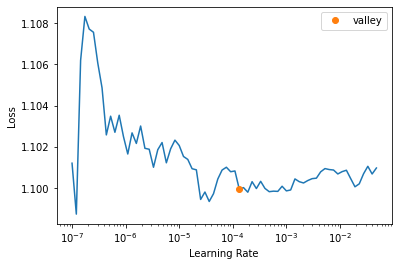

In [47]:
learn.lr_find()

In [ ]:
## BINARY

# learn.fit_one_cycle(5, lr_max=7e-4) 86% accuracy  32, 2 layers 64 -> 256 -> 64
# learn.fit_one_cycle(15, lr_max=0.0003) 87.7% accuracy 64  2 layers 128 -> 512 -> 64
# learn.fit_one_cycle(15, lr_max=0.0014) 87.9% accuracy 64  2 layers, bidirectional  256 -> 512 -> 64

## MULTI-CLASS

# learn.fit_one_cycle(15, lr_max= 0.0001) 67.3 accuracy 32 4 layers, bidirectional 256 -> 350 -> 420 -> 672 -> 1024 -> 2048 -> 256 -> 64
learn.fit_one_cycle(10, lr_max= 0.0001)

epoch,train_loss,valid_loss,accuracy,time
0,1.096067,1.094936,0.356190,10:28
1,1.094725,1.094590,0.355921,12:43
